# Schema Usage

The schema does not actually store any data.  Instead, it is an interface which allows us to interact with numpy/torch tensors in a semantic manner.  It lets us convert between storage vectors (i.e. how we store the building parameters numerically on disk), simulation objects (e.g. Archetypal Templates and PyUmi Shoeboxes) and machine learning model imports (i.e. torch tensors with full hourly schedule data).

## Notebook setup

We need some jank to get relative imports working.

In [1]:
import os
import sys
from nrel_uitls import CLIMATEZONES, RESTYPES
import json
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Initialize the Schema

In [3]:
from schema import Schema, ShoeboxGeometryParameter, BuildingTemplateParameter, WhiteboxSimulation, WindowParameter, SchedulesParameters
schema = Schema()

Let's see what's in the schema:

In [4]:
schema.parameter_names

['batch_id',
 'variation_id',
 'program_type',
 'vintage',
 'climate_zone',
 'base_epw',
 'width',
 'height',
 'facade_2_footprint',
 'perim_2_footprint',
 'roof_2_footprint',
 'footprint_2_ground',
 'shading_fact',
 'wwr',
 'orientation',
 'HeatingSetpoint',
 'CoolingSetpoint',
 'HeatingCoeffOfPerf',
 'CoolingCoeffOfPerf',
 'FlowRatePerFloorArea',
 'LightingPowerDensity',
 'EquipmentPowerDensity',
 'PeopleDensity',
 'Infiltration',
 'FacadeMass',
 'RoofMass',
 'FacadeRValue',
 'RoofRValue',
 'SlabRValue',
 'WindowSettings',
 'schedules_seed',
 'schedules']

We can access a schema parameter from the schema with list indexing:

In [5]:
print(schema["width"])
print(schema["schedules"])
print(schema["orientation"])

---width---
shape_storage=(1,), shape_ml=(1,), dtype=scalar
Width [m]
---schedules---
shape_storage=(3, 21), shape_ml=(3, 8760), dtype=matrix
A matrix in the storage vector with operations to apply to schedules; a matrix of timeseries in ml vector
---orientation---
shape_storage=(1,), shape_ml=(4,), dtype=onehot
Shoebox Orientation


We see that each parameter may have multiple different lengths in the storage vector and ML vector.

We can also print a summary of the whole schema:

In [6]:
print(schema)

-------- Schema --------
---- batch_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 0->1 / location ml: 0->0

---- variation_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 1->2 / location ml: 0->0

---- program_type ----
shape storage: (1,) / shape ml: (19,)
location storage: 2->3 / location ml: 0->19

---- vintage ----
shape storage: (1,) / shape ml: (1,)
location storage: 3->4 / location ml: 19->20

---- climate_zone ----
shape storage: (1,) / shape ml: (15,)
location storage: 4->5 / location ml: 20->35

---- base_epw ----
shape storage: (1,) / shape ml: (0,)
location storage: 5->6 / location ml: 35->35

---- width ----
shape storage: (1,) / shape ml: (1,)
location storage: 6->7 / location ml: 35->36

---- height ----
shape storage: (1,) / shape ml: (1,)
location storage: 7->8 / location ml: 36->37

---- facade_2_footprint ----
shape storage: (1,) / shape ml: (1,)
location storage: 8->9 / location ml: 37->38

---- perim_2_footprint ----
shape storage: (

We see that the length of the storage vector is significantly smaller than the length the vector the ML model will see.

## Generating new design vectors in storage space

First let's generate a new, empty design vector, and update the Roof R-Value, and then check that it updated correctly:

In [7]:
storage_vector = schema.generate_empty_storage_vector()
schema.update_storage_vector(storage_vector=storage_vector, parameter="RoofRValue", value=2.5)
schema["RoofRValue"].extract_storage_values(storage_vector)

2.5

If we print out the full vector, we should be able to see the 2.5 and a whole bunch of zeros (and a few 1s in the schedules indicated to use the original schedules):

In [8]:
print(storage_vector)

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  2.5 0.  0.  0.  0.  0.  0.  0.  0.
 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0. ]


Let's create a new batch of designs:

In [9]:
batch_size = 20
storage_batch = schema.generate_empty_storage_batch(batch_size)
storage_batch.shape

(20, 96)

Great, we see that it has 20 design vectors with 90 values each.

Let's try updating all of the facade R-values values in a batch with the same value:

In [10]:
schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=1.2)
schema["FacadeRValue"].extract_storage_values_batch(storage_batch)

array([[1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2]])

Now let's try updating an entire batch with random values.  We can also unnormalize the uniform random variable into the desired range:

In [11]:
parameter = "SlabRValue"
n = batch_size
shape = (n, *schema[parameter].shape_storage)
values = np.random.rand(*shape) # create a random sample with appropriate shape
values = schema[parameter].unnormalize(values) # schema parameter must be a numeric type with min/max defined for unnormalize to work
schema.update_storage_batch(storage_batch, parameter=parameter, value=values)
schema[parameter].extract_storage_values_batch(storage_batch)

array([[4.16683443],
       [4.44758019],
       [1.75795904],
       [2.92641207],
       [4.17089721],
       [3.84486366],
       [2.3427911 ],
       [1.74737936],
       [4.18978015],
       [0.87662468],
       [3.45624754],
       [2.94744256],
       [2.67637901],
       [3.45555738],
       [3.15465657],
       [3.5313565 ],
       [1.69781974],
       [0.61818204],
       [1.47866643],
       [1.59811892]])

Finally, let's try updating just a subset of the batch by using the `index` parameter:

*nb: we can also use an int instead of a tuple for `index` to only update a single vector's parameter*

In [12]:
start = 2
n = 8
end = start + n
parameter = "FacadeRValue"
shape = (n, *schema[parameter].shape_storage)
values = np.random.rand(*shape) # create a random sample with appropriate shape

schema.update_storage_batch(storage_batch, index=(start,end), parameter=parameter, value=values)
schema[parameter].extract_storage_values_batch(storage_batch) 

array([[1.2       ],
       [1.2       ],
       [0.76728282],
       [0.24699509],
       [0.63811032],
       [0.34605207],
       [0.10317988],
       [0.57087096],
       [0.85271093],
       [0.95474527],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ]])

A useful technique will be to start with a small batch, and then duplicate it in concatenations along `axis=0` as we build up our mixed grid/hypercube/random samples.  Let's start by creating a new batch with a single vector.

In [13]:
storage_batch = schema.generate_empty_storage_batch(1)
storage_batch.shape

(1, 96)

Now let's say some baseline parameters (e.g. pulled from ResStock)

In [14]:
with open("./data/city_map.json","r") as f:
	city_map = json.load(f)

schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=2.3)
schema.update_storage_batch(storage_batch, parameter="RoofRValue", value=3.1)
schema.update_storage_batch(storage_batch, parameter="LightingPowerDensity", value=7.2)
schema.update_storage_batch(storage_batch, parameter="program_type", value=RESTYPES["Multi-Family with 5+ Units"])
schema.update_storage_batch(storage_batch, parameter="vintage", value=1920)
schema.update_storage_batch(storage_batch, parameter="climate_zone", value=CLIMATEZONES["5A"])
schema.update_storage_batch(storage_batch, parameter="base_epw", value=city_map["FL, Lehigh Acres"]["idx"])
storage_batch = np.concatenate([storage_batch for _ in range(4)], axis=0)
storage_batch

array([[0.00e+00, 0.00e+00, 3.00e+00, 1.92e+03, 1.20e+01, 2.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 7.20e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 2.30e+00, 3.10e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

Now let's set the orientations:

In [15]:
values = np.arange(4).reshape(-1,1)
parameter = "orientation"
schema.update_storage_batch(storage_batch, parameter=parameter, value=values)
schema[parameter].extract_storage_values_batch(storage_batch)

array([[0.],
       [1.],
       [2.],
       [3.]])

Looks good!  Now let's stack this up and begin generating some geometric variations.

In [16]:
orientations_per_base = 4
geometric_variations_per_orientation = 5

In [17]:
storage_batch = np.repeat(storage_batch, geometric_variations_per_orientation, axis=0)
storage_batch.shape

(20, 96)

In [18]:
schema["orientation"].extract_storage_values_batch(storage_batch)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

Looks good!  let's start populating this: if we wanted to use repeating values, we could do nested loops:

In [19]:
n = geometric_variations_per_orientation # how many design vectors in this mini batch
for i in range(orientations_per_base):
	start = i*n # where this mini batch starts in the parent batch
	end = start + n # where this mini batch ends in the parent batch
	for j,parameter in enumerate(schema.parameters):
		if isinstance(parameter, ShoeboxGeometryParameter):
			name = parameter.name
			mean = parameter.mean
			std = parameter.std
			shape = parameter.shape_storage
			np.random.seed(j+20923) # arbitrary but reliable seed
			values = np.random.normal(loc=mean, scale=std, size=(n, *shape))
			# values = parameter.unnormalize(values)
			schema.update_storage_batch(storage_batch, index=(start,end), parameter=name, value=values)


In [20]:
schema["wwr"].extract_storage_values_batch(storage_batch)

array([[0.34444465],
       [0.05      ],
       [0.33708715],
       [0.16022385],
       [0.56547156],
       [0.34444465],
       [0.05      ],
       [0.33708715],
       [0.16022385],
       [0.56547156],
       [0.34444465],
       [0.05      ],
       [0.33708715],
       [0.16022385],
       [0.56547156],
       [0.34444465],
       [0.05      ],
       [0.33708715],
       [0.16022385],
       [0.56547156]])

In [21]:
schema["width"].extract_storage_values_batch(storage_batch)

array([[4.53980835],
       [7.08775209],
       [5.68124462],
       [5.36848356],
       [4.65878866],
       [4.53980835],
       [7.08775209],
       [5.68124462],
       [5.36848356],
       [4.65878866],
       [4.53980835],
       [7.08775209],
       [5.68124462],
       [5.36848356],
       [4.65878866],
       [4.53980835],
       [7.08775209],
       [5.68124462],
       [5.36848356],
       [4.65878866]])

Great, these are repeating correctly!  Now, suppose we want to just slightly perturb all of these so that they aren't perfectly repeating, but are close to repeating:

In [22]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
	if isinstance(parameter, ShoeboxGeometryParameter):
		name = parameter.name
		shape = parameter.shape_storage
		perturbations = np.random.rand(n,*shape)*0.2 - 0.1
		values = parameter.extract_storage_values_batch(storage_batch)
		values += perturbations
		schema.update_storage_batch(storage_batch,parameter=name,value=values)

schema["width"].extract_storage_values_batch(storage_batch)

array([[4.50783096],
       [7.10805712],
       [5.70969198],
       [5.27921971],
       [4.61290778],
       [4.44565827],
       [7.10161841],
       [5.69719431],
       [5.2850572 ],
       [4.58177482],
       [4.47766668],
       [7.1182584 ],
       [5.75855261],
       [5.42826064],
       [4.59308603],
       [4.57370062],
       [7.10369615],
       [5.5915765 ],
       [5.33658159],
       [4.63718082]])

Great!  We see that they are close to their previous values, but not identical.  

Alternatively, we might prefer to simply use fully random geometric variations for all of our orientation duplicates, rather than repeating the geometry across orientations:

In [23]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
	if isinstance(parameter, ShoeboxGeometryParameter):
		name = parameter.name
		shape = parameter.shape_storage
		values = np.random.rand(n,*shape)
		values = parameter.unnormalize(values)
		schema.update_storage_batch(storage_batch,parameter=name,value=values)

schema["width"].extract_storage_values_batch(storage_batch)
schema["wwr"].extract_storage_values_batch(storage_batch)

array([[0.4432166 ],
       [0.33710959],
       [0.4739605 ],
       [0.82761665],
       [0.81276337],
       [0.40249355],
       [0.22704208],
       [0.49019141],
       [0.06389378],
       [0.64614621],
       [0.75214811],
       [0.39788008],
       [0.25404495],
       [0.56076387],
       [0.15108382],
       [0.256085  ],
       [0.34024429],
       [0.42906409],
       [0.47522886],
       [0.61353465]])

Or, if a normal distribution is desired, we can do that as well:

In [24]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
    if isinstance(parameter, ShoeboxGeometryParameter):
        name = parameter.name
        mean = parameter.mean
        std = parameter.std
        shape = parameter.shape_storage
        values = np.random.normal(loc=mean, scale=std, size=(n,*shape))
        schema.update_storage_batch(storage_batch,parameter=name,value=values)

schema["width"].extract_storage_values_batch(storage_batch)
schema["wwr"].extract_storage_values_batch(storage_batch)

array([[0.21695047],
       [0.6391094 ],
       [0.29529725],
       [0.05      ],
       [0.32881206],
       [0.43934897],
       [0.28292817],
       [0.05      ],
       [0.82733875],
       [0.15145752],
       [0.27136917],
       [0.09045884],
       [0.26192168],
       [0.24751366],
       [0.39748335],
       [0.28785416],
       [0.49790465],
       [0.52373069],
       [0.35036656],
       [0.14348296]])

Later on in this file, we will be inspecting template parameters as well, so let's just arbitrarily set some building template parameters for each design:

In [25]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
	if isinstance(parameter, (BuildingTemplateParameter, WindowParameter)):
		name = parameter.name
		mean = parameter.mean
		std = parameter.std
		shape = parameter.shape_storage
		values = np.random.normal(loc=mean, scale=std, size=(n,*shape))
		schema.update_storage_batch(storage_batch,parameter=name,value=values)

print("LPD:")
print(schema["LightingPowerDensity"].extract_storage_values_batch(storage_batch)[:3])
print("Window Settings:")
print(schema["WindowSettings"].extract_storage_values_batch(storage_batch)[:3])

LPD:
[[5.73466772]
 [7.68669191]
 [9.37173696]]
Window Settings:
[[3.14958077 0.60625715 0.41883353]
 [6.04476975 0.48973266 0.66778925]
 [6.17792006 0.45298213 0.49137614]]


Suppose this was our finished batch.  We can save it to an HDF5 file.  Let's say this was building 23 from our ResStock database.

In [26]:
import h5py
from storage import upload_to_bucket

In [27]:
# Update the building IDs
batch_id = 23 # suppose this is the base building we are drawing from
n = storage_batch.shape[0]
variation_ids = np.arange(n)
schema.update_storage_batch(storage_batch,parameter="batch_id",value=batch_id)
schema.update_storage_batch(storage_batch,parameter="variation_id",value=variation_ids)

# Write to an HDF5 file
slug = f"batch_{batch_id:05d}.hdf5"
outfile = f"./data/hdf5/{slug}"
with h5py.File(outfile,"w") as f:
    f.create_dataset(name="storage_vectors", shape=storage_batch.shape, dtype=storage_batch.dtype, data=storage_batch)

# upload to cloud bucket for easy backup
destination = f"demo-batch-data/{slug}"
upload_to_bucket(destination, outfile)


INFO:Storage:Uploading ./data/hdf5/batch_00023.hdf5 to bucket:demo-batch-data/batch_00023.hdf5...
INFO:Storage:Done uploading.


## Simulation

Now let's suppose you want to simulate a design vector.  Let's open up an HDF5 file and read in only the first storage vector to get started.

In [28]:
batch_id = 23
slug = f"batch_{batch_id:05d}.hdf5"
outfile = f"./data/hdf5/{slug}"
storage_vector = None
with h5py.File(outfile,'r') as f:
    storage_vector = f["storage_vectors"][0]

schema["batch_id"].extract_storage_values(storage_vector), schema["variation_id"].extract_storage_values(storage_vector)

(23.0, 0.0)

Great! Looks like we successfully opened the 0th design variation from batch 23.

Now let's create a simulation object for this storage vector:

In [29]:
with h5py.File(outfile,'r') as f:
    storage_vector = f["storage_vectors"][0]
# just using 
# TODO: orientation
# TODO: setpoint value overlaps
# TODO: Fix template Selector
# TODO: window u value coming out different
schema.update_storage_vector(storage_vector, parameter="climate_zone", value=CLIMATEZONES["3A"])
schema.update_storage_vector(storage_vector, parameter="vintage", value=1920)
schema.update_storage_vector(storage_vector, parameter="program_type", value=RESTYPES["Multi-Family with 5+ Units"])
schema.update_storage_vector(storage_vector, parameter="base_epw", value=city_map["NY, New York"]["idx"])
schema.update_storage_vector(storage_vector, "height", 3)
schema.update_storage_vector(storage_vector, "width", 3)
schema.update_storage_vector(storage_vector, "facade_2_footprint", 0.3)
schema.update_storage_vector(storage_vector, "perim_2_footprint", 0.25)
schema.update_storage_vector(storage_vector, "roof_2_footprint", 0.5)
schema.update_storage_vector(storage_vector, "footprint_2_ground", 0.5)
schema.update_storage_vector(storage_vector, "wwr", 0.4)
schema.update_storage_vector(storage_vector, "Infiltration", 1.1)
schema.update_storage_vector(storage_vector, "HeatingSetpoint", 17)
schema.update_storage_vector(storage_vector, "CoolingSetpoint", 22)
schema.update_storage_vector(storage_vector, "PeopleDensity", 0.05)
schema.update_storage_vector(storage_vector, "LightingPowerDensity", 5)
schema.update_storage_vector(storage_vector, "EquipmentPowerDensity", 7)
schema.update_storage_vector(storage_vector, "RoofRValue", 1)
schema.update_storage_vector(storage_vector, "SlabRValue", 0.9)
schema.update_storage_vector(storage_vector, "FacadeRValue", 1)
schema.update_storage_vector(storage_vector, "FacadeMass", 120000)
schema.update_storage_vector(storage_vector, "RoofMass", 120000)
schema.update_storage_vector(storage_vector, "WindowSettings", np.array([2,0.5,0.5])) 

schedules = schema["schedules"].extract_storage_values(storage_vector)
sched_demo = "SINE"
if sched_demo == "BASELINE":
    # Equipment
    # pass
    # Occupancy
    schedules[1, SchedulesParameters.op_indices["noise"]] = 0.2
    # Lights
    schedules[2, SchedulesParameters.op_indices["invert"]] = 1
elif sched_demo == "SINE":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["sin_overwrite"]] = 1
    schedules[0, SchedulesParameters.op_indices["sin_0_amp"]] = 0.5
    schedules[0, SchedulesParameters.op_indices["sin_0_freq"]] = 365
    # Occupancy
    schedules[1, SchedulesParameters.op_indices["sin_overwrite"]] = 1
    schedules[1, SchedulesParameters.op_indices["sin_0_amp"]] = 0.5
    schedules[1, SchedulesParameters.op_indices["sin_0_freq"]] = 365
    schedules[1, SchedulesParameters.op_indices["sin_1_amp"]] = 0.5
    schedules[1, SchedulesParameters.op_indices["sin_1_freq"]] = 4
    # Lights
    schedules[2, SchedulesParameters.op_indices["sin_overwrite"]] = 1
    schedules[2, SchedulesParameters.op_indices["sin_0_amp"]] = 1.0
    schedules[2, SchedulesParameters.op_indices["sin_0_freq"]] = 24 # 2 per mo
elif sched_demo == "BERNOULLI":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[0, SchedulesParameters.op_indices["uniform_random_samples"]] = 10 # samples per pattern
    schedules[0, SchedulesParameters.op_indices["uniform_random_mode"]] = 1 # bernoulli
    # Occupancy
    schedules[1, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[1, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # samples per pattern
    schedules[1, SchedulesParameters.op_indices["uniform_random_mode"]] = 1 # bernoulli
    # Lights
    schedules[2, SchedulesParameters.op_indices["uniform_random_dilation"]] = 24 # hours per sample
    schedules[2, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # samples per pattern
    schedules[2, SchedulesParameters.op_indices["uniform_random_mode"]] = 1 # bernoulli
elif sched_demo == "UNI_RAND":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[0, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # samples per pattern
    schedules[0, SchedulesParameters.op_indices["uniform_random_mode"]] = 0 # continuous

    # Occupancy
    schedules[1, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[1, SchedulesParameters.op_indices["uniform_random_samples"]] = 24 # samples per pattern
    schedules[1, SchedulesParameters.op_indices["uniform_random_mode"]] = 0 # continuous

    # Lights
    schedules[2, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[2, SchedulesParameters.op_indices["uniform_random_samples"]] = 24 # samples per pattern
    schedules[2, SchedulesParameters.op_indices["uniform_random_mode"]] = 0 # continuous
elif sched_demo == "PULSE":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["pulse_period"]] = 24*7 # 7 day cycle
    schedules[0, SchedulesParameters.op_indices["pulse_width"]] = 24*5 # on for 5 days

    # Occupancy
    schedules[1, SchedulesParameters.op_indices["pulse_period"]] = 24 # 1 day cycle
    schedules[1, SchedulesParameters.op_indices["pulse_width"]] = 15 # on for 5 days

    # Lights
    schedules[2, SchedulesParameters.op_indices["pulse_period"]] = 23 # 23 hr cycle
    schedules[2, SchedulesParameters.op_indices["pulse_width"]] = 18 # on for 11 hrs



whitebox_sim = WhiteboxSimulation(schema, storage_vector)
# whitebox_sim.shoebox.view_model()
# whitebox_sim.summarize()

8760
0.192 0.698 0.4202775114155251
8760
0.194 0.923 0.41548242009132424
8760
0.242 0.966 0.6694399543378995


INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.


0.Perimeter.Loads.EquipmentAvailabilitySchedule: mean daily min:0.00 mean:0.25 max:0.50 quantity 7.0

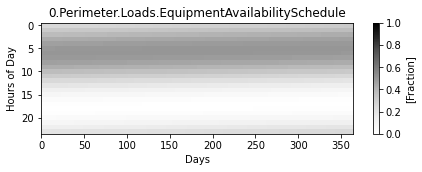

In [30]:
whitebox_sim.template.Perimeter.Loads.EquipmentAvailabilitySchedule

0.Perimeter.Loads.LightsAvailabilitySchedule: mean daily min:0.25 mean:0.50 max:0.75 quantity 5.0

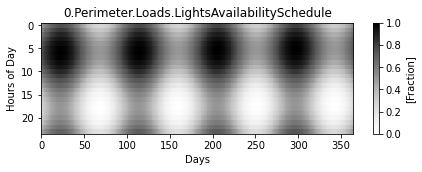

In [31]:
whitebox_sim.template.Perimeter.Loads.LightsAvailabilitySchedule

0.Perimeter.Loads.OccupancySchedule: mean daily min:0.44 mean:0.50 max:0.56 quantity 0.05

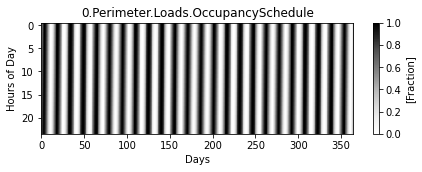

In [32]:
whitebox_sim.template.Perimeter.Loads.OccupancySchedule

Great!  Jeez I'm saying that a lot in this notebook.

Let's run an actual simulation.

In [33]:
%%capture
# capture hides output
res_hourly, res_monthly = whitebox_sim.simulate()

INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:ExpandObjects Started.
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf: Begin reading Energy+.idd file.
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf: Done reading Energy+.idd file.
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.156
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:ExpandObjects completed in 0.33 seconds
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:Simulation started
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:EnergyPlus Starting
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.05.14 06:39
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:Adjusting Air System Sizing
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:Initializing Simulation
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:Reporting Surfaces
INFO:5f1e7ccc-f25c-11ed-b93c-841b77d62e9a.idf:Beginning Primary Simu

Looks like it simulated successfully! Let's confirm by taking a look at the the tables.

In [34]:
res_hourly.head()

IndexGroup                                               System  \
KeyValue            BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM   
Name                 Zone Ideal Loads Zone Total Heating Energy   
2018-01-01 00:00:00                                1.653530e+06   
2018-01-01 01:00:00                                1.639425e+06   
2018-01-01 02:00:00                                1.648007e+06   
2018-01-01 03:00:00                                1.659882e+06   
2018-01-01 04:00:00                                1.675348e+06   

IndexGroup                                                      \
KeyValue                                                         
Name                Zone Ideal Loads Zone Total Cooling Energy   
2018-01-01 00:00:00                               1.652438e-08   
2018-01-01 01:00:00                               2.880256e-08   
2018-01-01 02:00:00                               2.936531e-08   
2018-01-01 03:00:00                               5.392167e-08   
2018-01-01 04:00:00                               4.097842e-08   

IndexGroup                                                      \
KeyValue            BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM   
Name                Zone Ideal Loads Zone Total Heating Energy   
2018-01-01 00:00:00                               4.763645e+06   
2018-01-01 01:00:00                               4.626103e+06   
2018-01-01 02:00:00                               4.525165e+06   
2018-01-01 03:00:00                               4.450879e+06   
2018-01-01 04:00:00                               4.404435e+06   

IndexGroup                                                      
KeyValue                                                        
Name                Zone Ideal Loads Zone Total Cooling Energy  
2018-01-01 00:00:00                               1.352646e-07  
2018-01-01 01:00:00                               1.166427e-07  
2018-01-01 02:00:00                               4.890808e-08  
2018-01-01 03:00:00                               1.847866e-07  
2018-01-01 04:00:00                               2.435172e-08

In [35]:
res_monthly

IndexGroup                                      System  \
KeyValue   BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM   
Name        Zone Ideal Loads Zone Total Heating Energy   
2018-01-01                                1.242688e+09   
2018-02-01                                7.682511e+08   
2018-03-01                                4.860955e+08   
2018-04-01                                2.072242e+08   
2018-05-01                                5.379835e+07   
2018-06-01                                2.072754e-06   
2018-07-01                                0.000000e+00   
2018-08-01                                1.356763e+00   
2018-09-01                                1.783797e+06   
2018-10-01                                1.180315e+08   
2018-11-01                                4.071481e+08   
2018-12-01                                9.877664e+08   

IndexGroup                                             \
KeyValue                                                
Name       Zone Ideal Loads Zone Total Cooling Energy   
2018-01-01                               6.962926e+05   
2018-02-01                               1.347360e+07   
2018-03-01                               8.292941e+07   
2018-04-01                               1.691482e+08   
2018-05-01                               4.343648e+08   
2018-06-01                               7.272505e+08   
2018-07-01                               1.182658e+09   
2018-08-01                               9.693069e+08   
2018-09-01                               6.161035e+08   
2018-10-01                               1.988155e+08   
2018-11-01                               1.018665e+08   
2018-12-01                               3.376008e+06   

IndexGroup                                             \
KeyValue   BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM   
Name       Zone Ideal Loads Zone Total Heating Energy   
2018-01-01                               3.933453e+09   
2018-02-01                               2.721621e+09   
2018-03-01                               1.816316e+09   
2018-04-01                               7.446027e+08   
2018-05-01                               1.868977e+08   
2018-06-01                               1.587962e-06   
2018-07-01                               0.000000e+00   
2018-08-01                               1.224332e-06   
2018-09-01                               1.119561e+07   
2018-10-01                               5.525702e+08   
2018-11-01                               1.403568e+09   
2018-12-01                               3.192484e+09   

IndexGroup                                             
KeyValue                                               
Name       Zone Ideal Loads Zone Total Cooling Energy  
2018-01-01                               5.635615e+02  
2018-02-01                               1.369419e+03  
2018-03-01                               2.973689e+06  
2018-04-01                               9.582321e+07  
2018-05-01                               5.208823e+08  
2018-06-01                               1.026083e+09  
2018-07-01                               2.030268e+09  
2018-08-01                               1.371209e+09  
2018-09-01                               5.123239e+08  
2018-10-01                               1.123384e+07  
2018-11-01                               4.455492e+02  
2018-12-01                               5.946709e+02

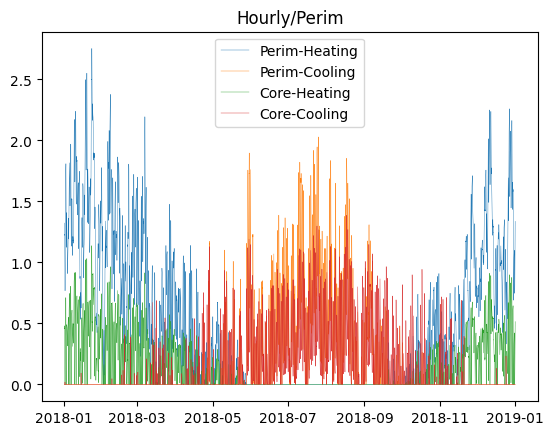

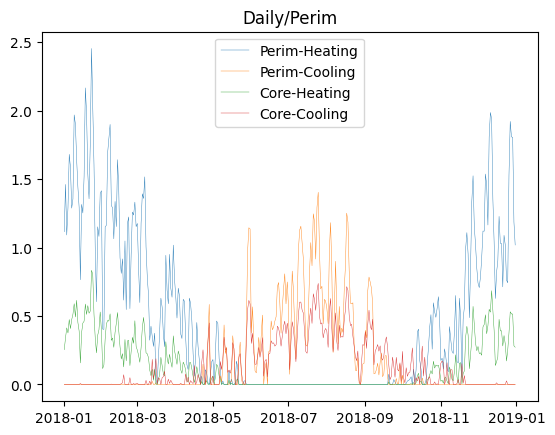

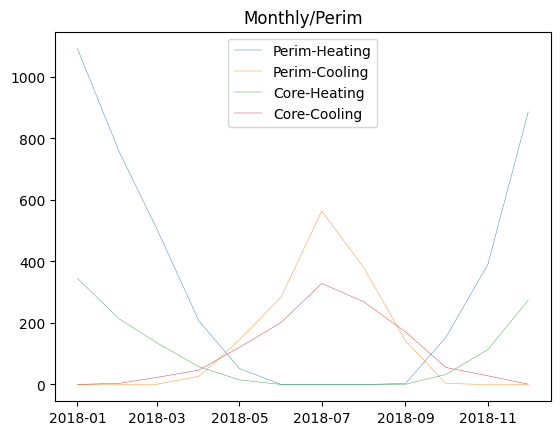

In [43]:
fig = plt.figure()
plt.plot(res_hourly["System"]["BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM"]*2.777e-7, linewidth=0.3, label=["Perim-Heating", "Perim-Cooling"])
txt = plt.title("Hourly/Core")

plt.plot(res_hourly["System"]["BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM"]*2.777e-7, linewidth=0.3, label=["Core-Heating", "Core-Cooling"])
txt = plt.title("Hourly/Perim")
plt.legend()

fig = plt.figure()
plt.plot(res_hourly["System"]["BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM"].resample("1D").mean()*2.777e-7, linewidth=0.3, label=["Perim-Heating", "Perim-Cooling"])
txt = plt.title("Daily/Core")

plt.plot(res_hourly["System"]["BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM"].resample("1D").mean()*2.777e-7, linewidth=0.3, label=["Core-Heating", "Core-Cooling"])
txt = plt.title("Daily/Perim")
plt.legend()


fig = plt.figure()
plt.plot(res_monthly["System"]["BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM"]*2.777e-7, linewidth=0.3, label=["Perim-Heating", "Perim-Cooling"])
txt = plt.title("Monthly/Core")

plt.plot(res_monthly["System"]["BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM"]*2.777e-7, linewidth=0.3, label=["Core-Heating", "Core-Cooling"])
txt = plt.title("Monthly/Perim")
leg =plt.legend()

## Batch Simulation

Now let's take a look at simulating a whole batch.

First, we need to instantiate the batch simulator.  This configures an object which will automatically handle identifying and opening the correct storage vector batch, and can automatically run simulations in parallel and write results to a new HDF5 file.  It will also automatically upload the results files to the cloud bucket.

*nb: `simulate.py` can be called from the CLI in order to facilitate easily launching many Batches simultaneously from many processes running on multiple servers, i.e.* `python simulate.py <batch_id> <n of processes>`

In [ ]:
from simulate import BatchSimulator
batch_runner = BatchSimulator(schema, batch_id=23, processes=5)

To simulate, all we need to do is call the `run` method!

In [ ]:
%%capture
batch_runner.run()

Afterwards, we can automatically upload the results to the Google storage bucket:

In [ ]:
batch_runner.upload()

Let's take a look at some results:

In [ ]:
results = None
with h5py.File("./data/hdf5/batch_00023_results.hdf5", 'r') as f:
    results = f["hourly"][...] # this loads the whole batch into memory!

print(results.shape)



In [ ]:
fig = plt.figure()
plt.plot(results[0,0,:]*2.777e-7, linewidth=0.5)
plt.plot(results[0,1,:]*2.777e-7, linewidth=0.5)
fig = plt.figure()
plt.plot(results[0,2,:]*2.777e-7, linewidth=0.5)
plt.plot(results[0,3,:]*2.777e-7, linewidth=0.5)